## Import modules, packages and libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import roc_curve, auc
from scipy import stats
from collections import OrderedDict
import graphviz

## Load the pre-processed `Loan` data set

In [3]:
df = pd.read_csv("cleaned_data.csv")

## Recoding the categorical variables

In [4]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# convert term to int (either 36 or 60)
df['term'] = list(map(lambda t: int(str(t)[0:3]), df['term']))

# emp_length map from 0 to 10 (< 1 -> 0 and 10+ -> 10)
def map_emp_length(emp_length):
    temp = str(emp_length)[0:2]
    if temp == '< ':
        temp = '0'
    if temp == 'na':
        temp = '0'
    return int(temp)
df['emp_length'] = list(map(map_emp_length, df['emp_length']))

# convert initial_list_status to numerical (dummy) values
mapping_dictionary = {'initial_list_status':{ 'w': 1, 'f': 0}}
df = df.replace(mapping_dictionary)

# convert home_ownership using one-hot encoding
home_encoding = pd.get_dummies(df['home_ownership'])
df = pd.concat([df, home_encoding], axis=1)
df.drop('home_ownership', axis=1, inplace=True)

# convert verification_status using one-hot encoding
verification_status = pd.get_dummies(df['verification_status'])
df = pd.concat([df, verification_status], axis=1)
df.drop('verification_status', axis=1, inplace=True)

# convert purpose using one-hot encoding
purpose = pd.get_dummies(df['purpose'])
df = pd.concat([df, purpose], axis=1)
df.drop('purpose', axis=1, inplace=True)

# convert sub_grade using consecutive integers
# (as there is a ranking between the values G5 -> A1)
mapping = {'A': 0, 'B': 5, 'C': 10, 'D': 15, 'E': 20, 'F': 25, 'G': 30}
df['sub_grade'] = list(map(lambda t: mapping[t[0]] + int(t[1]), df['sub_grade']))

# convert addr_state using one-hot encoding
addr_state = pd.get_dummies(df['addr_state'])
df = pd.concat([df, addr_state], axis=1)
df.drop('addr_state', axis=1, inplace=True)

# write to csv
df.to_csv("numerical_data.csv")

## Split the data set into training and test set

In [7]:
# get "loan status"
y = df["loan_status"]
# drop "loan status"
df.drop("loan_status", axis=1, inplace=True)

# split data into training and test sets (80% - 20%)
x_train, x_test, y_train, y_test = train_test_split(df, y, test_size = 0.2, random_state = 1)

## Scale the data

In [9]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()
scaler.fit(x_train[numerical_cols])

x_train[numerical_cols] = scaler.transform(x_train[numerical_cols])
x_test[numerical_cols] = scaler.transform(x_test[numerical_cols])

## Build a single decision tree with 5 features

In [10]:
chosen_features = ["sub_grade", "int_rate", "WY", "pub_rec_bankruptcies", "mo_sin_old_il_acct"]

x_train_5 = x_train[chosen_features]
x_test_5 = x_test[chosen_features]

# Create a decision tree classifier
dt = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=1)
# Train the classifier
dt.fit(x_train_5, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=1)

### Find information gain at the root node for all the chosen features

In [11]:
def gen_tree_with_one_feature(x_train, y_train, feature):
    x_train = x_train[feature]
    x_train = np.array(x_train).reshape(-1, 1)
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=1)
    dt.fit(x_train, y_train)

    initial_entropy = stats.entropy(y_train.value_counts(normalize=True), base=2)

    tree = dt.tree_
    
    expected_entropy = tree.impurity[1] * tree.n_node_samples[1] / tree.n_node_samples[0] + tree.impurity[2] * tree.n_node_samples[2] / tree.n_node_samples[0]
    print("Feature: ", feature)
    print("Information gain: ")
    print(initial_entropy - expected_entropy)
    print("Expected entropy: ",)
    print(expected_entropy)
    print("Threshold: ", tree.threshold[0])

In [12]:
for feature in chosen_features:
    gen_tree_with_one_feature(x_train_5, y_train, feature)

Feature:  sub_grade
Information gain: 
0.04018378302091008
Expected entropy: 
0.7448334102381606
Threshold:  -0.010406434535980225
Feature:  int_rate
Information gain: 
0.04045181300242984
Expected entropy: 
0.7445653802566409
Threshold:  -0.03119020164012909
Feature:  WY
Information gain: 
1.7324448283839722e-05
Expected entropy: 
0.7849998688107869
Threshold:  0.5
Feature:  pub_rec_bankruptcies
Information gain: 
0.0007402521381693061
Expected entropy: 
0.7842769411209014
Threshold:  0.8382716774940491
Feature:  mo_sin_old_il_acct
Information gain: 
0.0006268820597018498
Expected entropy: 
0.7843903111993689
Threshold:  -0.879920482635498


### Plot the final decision tree (generates a png)

In [13]:
# DOT data
dot_data = export_graphviz(dt, out_file=None, feature_names=x_train_5.columns, filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png")
graph.render("decision_tree_graphivz")

'decision_tree_graphivz.png'

### Compute confusion matrices for different thresholds

In [14]:
Q = dt.predict_proba(x_test_5)[:,1]

thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

for threshold in thresholds:
    predictions = np.where(Q > threshold, 1, 0)
    conf = np.round((confusion_matrix(y_test, predictions, sample_weight=None) / len(y_test)) * 100, 2)
    precision = precision_score(y_test, predictions)
    tpr = recall_score(y_test, predictions)
    fpr = conf[1][0] / (conf[1][0] + conf[1][1])

    print("Threshold: ", threshold)
    print("Confusion Matrix: ")
    print(conf)
    print("Precision: ", precision)
    print("True Positive Rate: ", tpr)
    print("False Positive Rate: ", fpr)
    print(tpr - fpr)

Threshold:  0.5
Confusion Matrix: 
[[ 1.15 22.29]
 [ 1.02 75.53]]
Precision:  0.7721210432844656
True Positive Rate:  0.9866945532217871
False Positive Rate:  0.01332462442847812
0.973369928793309
Threshold:  0.6
Confusion Matrix: 
[[ 5.17 18.27]
 [ 6.15 70.4 ]]
Precision:  0.7939379970035727
True Positive Rate:  0.9196778212887149
False Positive Rate:  0.08033964728935336
0.8393381739993615
Threshold:  0.7
Confusion Matrix: 
[[ 9.39 14.06]
 [13.58 62.97]]
Precision:  0.8174943616503781
True Positive Rate:  0.822623709505162
False Positive Rate:  0.1774003919007185
0.6452233176044435
Threshold:  0.8
Confusion Matrix: 
[[17.88  5.57]
 [38.41 38.14]]
Precision:  0.8726422447388932
True Positive Rate:  0.4982200071199715
False Positive Rate:  0.5017635532331809
-0.003543546113209395
Threshold:  0.9
Confusion Matrix: 
[[22.49  0.96]
 [63.69 12.86]]
Precision:  0.9304905102292335
True Positive Rate:  0.16798682805268778
False Positive Rate:  0.8320052253429131
-0.6640183972902254


### Plot the ROC

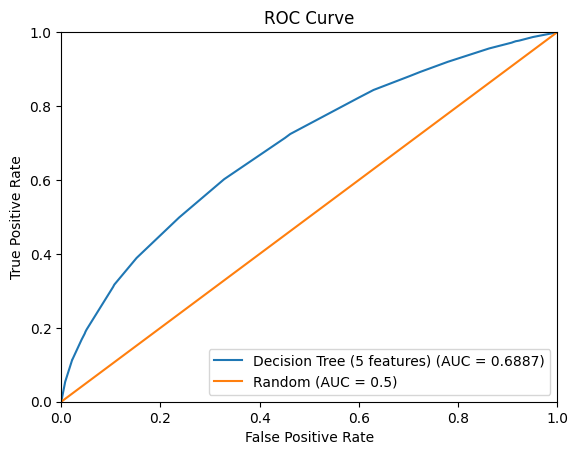

In [15]:
fpr, tpr, _ = roc_curve(y_test, Q)
dt_auc = auc(fpr,tpr)

plt.plot(fpr, tpr, label='Decision Tree (5 features) (AUC = %0.4f)' % dt_auc)
plt.plot([0, 1], [0, 1], label='Random (AUC = 0.5)' )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Build a single decision tree with 10 features

In [16]:
chosen_features = ["sub_grade", "int_rate", "term", "fico_range_avg", "dti", "acc_open_past_24mths", "mort_acc", "avg_cur_bal", "Not Verified", "MORTGAGE"]

x_train_10 = x_train[chosen_features]
x_test_10 = x_test[chosen_features]

dt = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=1)
dt.fit(x_train_10, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=1)

### Compute confusion matrices for different thresholds

In [17]:
Q = dt.predict_proba(x_test_10)[:,1]

thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

for threshold in thresholds:
    predictions = np.where(Q > threshold, 1, 0)
    conf = np.round((confusion_matrix(y_test, predictions, sample_weight=None) / len(y_test)) * 100, 2)
    precision = precision_score(y_test, predictions)
    tpr = recall_score(y_test, predictions)
    fpr = conf[1][0] / (conf[1][0] + conf[1][1])

    print("Threshold: ", threshold)
    print("Confusion Matrix: ")
    print(conf)
    print("Precision: ", precision)
    print("True Positive Rate: ", tpr)
    print("False Positive Rate: ", fpr)
    print(tpr - fpr)

Threshold:  0.5
Confusion Matrix: 
[[ 1.11 22.33]
 [ 0.87 75.69]]
Precision:  0.7721554180857719
True Positive Rate:  0.9886970452118191
False Positive Rate:  0.011363636363636364
0.9773334088481828
Threshold:  0.6
Confusion Matrix: 
[[ 5.05 18.4 ]
 [ 5.55 71.  ]]
Precision:  0.7942308425103837
True Positive Rate:  0.9275097899608401
False Positive Rate:  0.07250163291966036
0.8550081570411797
Threshold:  0.7
Confusion Matrix: 
[[ 9.84 13.61]
 [13.75 62.8 ]]
Precision:  0.8219269695483525
True Positive Rate:  0.8203542185831256
False Positive Rate:  0.17962116263879818
0.6407330559443274
Threshold:  0.8
Confusion Matrix: 
[[16.76  6.68]
 [32.85 43.7 ]]
Precision:  0.867342799188641
True Positive Rate:  0.5708437166251334
False Positive Rate:  0.4291312867406923
0.14171242988444116
Threshold:  0.9
Confusion Matrix: 
[[22.55  0.89]
 [63.61 12.94]]
Precision:  0.9354997538158543
True Positive Rate:  0.16909932360270558
False Positive Rate:  0.8309601567602874
-0.6618608331575819


### Plot the ROC

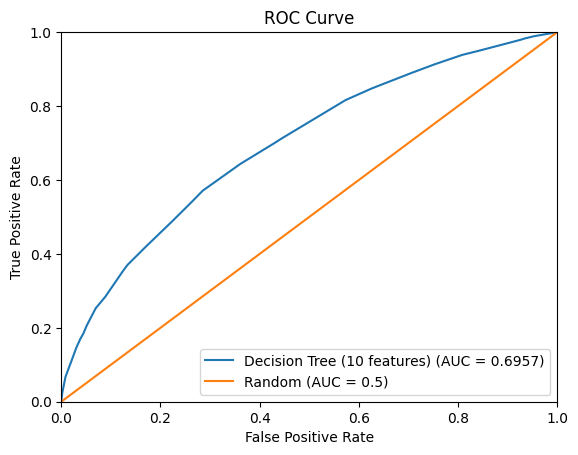

In [18]:
fpr, tpr, _ = roc_curve(y_test, Q)
dt_auc = auc(fpr,tpr)

plt.plot(fpr, tpr, label='Decision Tree (10 features) (AUC = %0.4f)' % dt_auc)
plt.plot([0, 1], [0, 1], label='Random (AUC = 0.5)' )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Build a Random Forest model

### Perform a grid search to get an idea of good values for the hyperparameters

In [ ]:
# To try finding the best parameters
# Disclaimer: Takes a long time to run
rf_initial = RandomForestClassifier(criterion="entropy", oob_score=True, random_state=1)
param_grid = {'n_estimators': [50, 180, 240, 500],
          'max_depth': [7, 14, 20],
          'min_samples_split': [2, 5, 10],
          'max_features': ['sqrt', 'log2']}

grid_rf = GridSearchCV(rf_initial, param_grid, cv=5)
grid_rf.fit(x_train, y_train)
print("Best parameters: ", grid_rf.best_params_)

# Found: 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 500

### Grow forests with chosen max_depth, max_features and an interval of n_estimators and compare their performance

In [20]:
forests = [
        (
            "max_depth=10, max_features='sqrt'",
            RandomForestClassifier
            (
                criterion="entropy",
                max_depth=10,
                oob_score=True,
                random_state=1,
                max_features="sqrt",
                warm_start=True,
            )
        ),
        (
            "max_depth=20, max_features='sqrt'",
            RandomForestClassifier
            (
                criterion="entropy",
                max_depth=20,
                oob_score=True,
                random_state=1,
                max_features="sqrt",
                warm_start=True,
            )
        ),
        (
            "max_depth=10, max_features='log2'",
            RandomForestClassifier
            (
                criterion="entropy",
                max_depth=10,
                oob_score=True,
                random_state=1,
                max_features="log2",
                warm_start=True,
            )
        ),
        (
            "max_depth=20, max_features='log2'",
            RandomForestClassifier
            (
                criterion="entropy",
                max_depth=20,
                oob_score=True,
                random_state=1,
                max_features="log2",
                warm_start=True,
            )
        )
    ]

/home/lukas/.local/lib/python3.10/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/lukas/.local/lib/python3.10/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/lukas/.local/lib/python3.10/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/lukas/.local/lib/python3.10/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/lukas/.local/lib/python3.10/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/lukas/.local/lib/python3.10/s

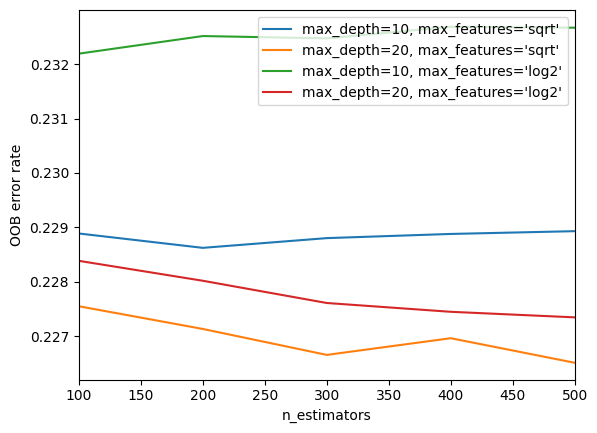

In [27]:
oob_errors = OrderedDict((label, []) for label, _ in forests)

for label, forest in forests:
    for i in range(100, 501, 100):
        forest.set_params(n_estimators=i)
        forest.fit(x_train, y_train)


        oob_error = 1 - forest.oob_score_
        oob_errors[label].append((i, oob_error))

for label, err in oob_errors.items():
    xs, ys = zip(*err)
    plt.plot(xs, ys, label=label)

plt.xlim(100, 500)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

### Compute confusion matrices for different thresholds of the best model

In [23]:
rf_best = RandomForestClassifier(criterion="entropy", oob_score=True, random_state=1, n_estimators=500, max_depth=20, max_features='sqrt')
rf_best.fit(x_train, y_train)
y_pred = rf_best.predict(x_test)
print("Final accuracy: ", accuracy_score(y_test, y_pred))

/home/lukas/.local/lib/python3.10/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Final accuracy:  0.771282575370465


In [24]:
Q = rf_best.predict_proba(x_test)[:,1]
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
for threshold in thresholds:
    predictions = np.where(Q > threshold, 1, 0)
    conf = np.round((confusion_matrix(y_test, predictions, sample_weight=None) / len(y_test)) * 100, 2)
    precision = precision_score(y_test, predictions)
    tpr = recall_score(y_test, predictions)
    fpr = conf[1][0] / (conf[1][0] + conf[1][1])

    print("Threshold: ", threshold)
    print("Confusion Matrix: ")
    print(conf)
    print("Precision: ", precision)
    print("True Positive Rate: ", tpr)
    print("False Positive Rate: ", fpr)
    print(1000*conf[1][1] - 4000*conf[0][1])

Threshold:  0.5
Confusion Matrix: 
[[ 1.97 21.48]
 [ 1.4  75.16]]
Precision:  0.7777621095677925
True Positive Rate:  0.9817550729797081
False Positive Rate:  0.018286311389759665
-10760.0
Threshold:  0.6
Confusion Matrix: 
[[ 5.77 17.67]
 [ 5.38 71.18]]
Precision:  0.8010888735526417
True Positive Rate:  0.9297792808828764
False Positive Rate:  0.07027168234064786
500.0
Threshold:  0.7
Confusion Matrix: 
[[11.54 11.91]
 [16.2  60.35]]
Precision:  0.8351876296435979
True Positive Rate:  0.7883588465646137
False Positive Rate:  0.2116263879817113
12710.0
Threshold:  0.8
Confusion Matrix: 
[[18.24  5.21]
 [36.46 40.09]]
Precision:  0.8850116567646837
True Positive Rate:  0.5236739053043787
False Positive Rate:  0.4762900065316786
19250.0
Threshold:  0.9
Confusion Matrix: 
[[22.75  0.7 ]
 [63.74 12.81]]
Precision:  0.9483106404437721
True Positive Rate:  0.16736383054467782
False Positive Rate:  0.8326583932070543
10010.0


### Plot the ROC

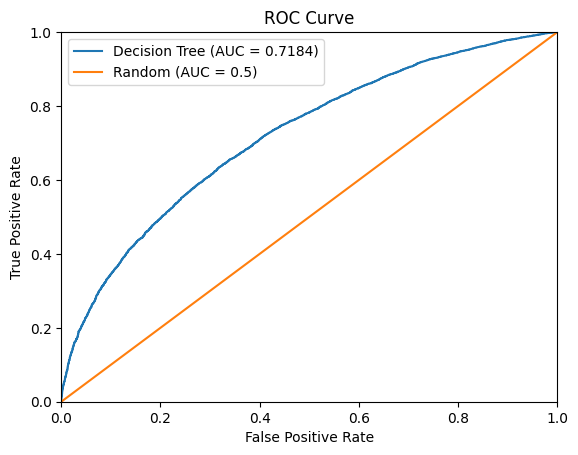

In [25]:
fpr, tpr, _ = roc_curve(y_test, Q)
dt_auc = auc(fpr,tpr)

plt.plot(fpr, tpr, label='Decision Tree (AUC = %0.4f)' % dt_auc)
plt.plot([0, 1], [0, 1], label='Random (AUC = 0.5)' )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Make a variable importance diagram (top 10 features)

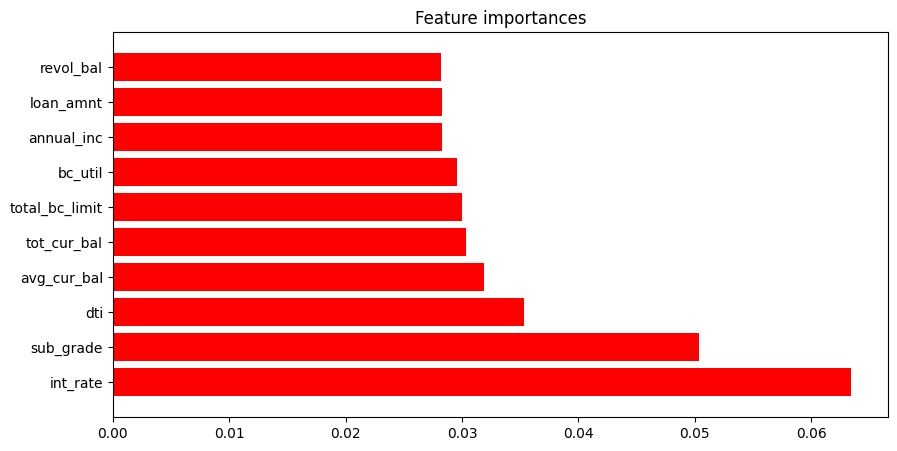

In [26]:
importances = rf_best.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Feature importances")
plt.barh(range(10), importances[indices][:10], color="r", align="center")
plt.yticks(range(10), x_train.columns[indices][:10])
plt.ylim([-1, 10])
plt.show()